Generative deep learining:
1. Text generation
2. Deep Dream
3. Neural style transfer
4. Variational Auto Encoders (VAE)
5. Generative adversial networks

Diffusion models, LLMs to be done after these in a different notebook

Language model : given n tokens, predict next token or a bunch of tokens studying the underlying latent space of languages [statistical structure].

Sampling strategy : you can predict the token based on greedy sampling [the token with the highest probability is chosen] - higher chance of repeated predictive text but very little scope for creativity.
adding a small amount of randomness makes the language model give out natural looking text. [stochastic sampling]

How to control the randomness? there has to be a measurable way to choose the amount of randomness, else how will you control how creative or rigid your language model needs to be?
Amount of entropy controlled by - softmax temperature.

Given a softmax temperature, the reweighted distribution is computed in the following way:


In [ ]:
import numpy as np
def reweight_distribution(original_distribution, temperature = 0.5):
  distribution = np.log(original_distribution) / temperature
  distribution = np.exp(distribution)
  return distribution / np.sum(distribution)

In [ ]:
#playing around with softmax to understand the softmax temperature
import tensorflow as tf
logits = np.array([1,2,3,4,5]).astype(np.float32)
softmax_output = tf.nn.softmax(logits)
print(softmax_output)

tf.Tensor([0.01165623 0.03168492 0.08612854 0.23412168 0.6364086 ], shape=(5,), dtype=float32)


0.01165623 0.03168492 0.08612854 0.23412168 0.6364086  - these are the softmax outputs for the original distribution i.e temperature of 1
let us now work with temperature of 0.5

In [ ]:
softmax_output_with_temp = reweight_distribution(softmax_output, temperature = 0.2)

In [ ]:
softmax_output_with_temp

array([2.0472677e-09, 3.0384146e-07, 4.5093984e-05, 6.6925501e-03,
       9.9326205e-01], dtype=float32)

2.0472677e-09, 3.0384146e-07, 4.5093984e-05, 6.6925501e-03,
       9.9326205e-01 - these are the new reweighted values. we see that with decrease in temperature, there is a convergence to a distribution where there is a clear winner with other values converging to zero and the winner converging to 1 i.e a unit impulse function.
       

In [ ]:
softmax_output_with_temp = reweight_distribution(softmax_output, temperature = 2.0)

In [ ]:
softmax_output_with_temp

array([0.05801222, 0.09564598, 0.15769355, 0.25999275, 0.4286555 ],
      dtype=float32)

with softmax temperature = 2.0, we see that is a convergence to a uniform distribution -> this way we get creative sequence prediction.
Different reweightings of one probability distribution. Low temperature = more deterministic, high temperature = more random.

Implementation of text generation with keras

trying to generate movie reviews based on movie review dataset used in previous notebooks. of course this will help our model generate texts like movie review and not general conversational english.

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2024-05-01 10:59:28--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  11.8MB/s    in 14s     

2024-05-01 10:59:43 (5.61 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
dataset = keras.utils.text_dataset_from_directory(directory='/content/aclImdb',label_mode=None,batch_size=256)

Found 100006 files belonging to 1 classes.


In [ ]:
dataset = dataset.map(lambda x : tf.strings.regex_replace(x,"<br />", " "))

In [ ]:
from keras.layers import TextVectorization


In [ ]:
sequence_length = 100
max_tokens = 15000
# max tokens to construct vocabulary - 15000 and we will have 100 tokens as inputs and 100 tokens as targets offset by 1
text_vectorization = TextVectorization(max_tokens = max_tokens, output_mode="int", output_sequence_length=sequence_length )

In [ ]:
text_vectorization.adapt(dataset)

In [ ]:
#preparation of lanugage model datasets
def prepare_lm_dataset(text_batch):
  vectorized_sequence = text_vectorization(text_batch)
  x = vectorized_sequence[:,:-1]
  y = vectorized_sequence[:,1:]
  return x,y


In [ ]:
lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

Few insights:
for text_generation we don't train based on token prediction i.e given n words just predict n+1 th token
instead we feed sequence of tokens 0...N and give 1...N+1 as the target sequence. because if we train by the former way, we ll always need N tokens to predict a token, otherwise it will lead to undefined behaviour
in the second case, for every token, we have a target token.
also, in former case, there is redundancy, we need to generate a lot of samples which have similar tokens and the model is made to work on redundant data.
in second case, N redundant but different token trainings are done togther.
In timeseries prediction, we adopted the former approach,because that was the task at hand. if we adopt the second method in timeseries prediction, we need to train to predict 119 times stamps along with target time stamp data severely underfitting our model.
the task is just to predict the time after 24 hrs given 120 days data.
with tokens, it works brilliantly.
we use the transformer decoder alone since there is separate source sequence and use causal mask for our model to look at previous data alone and not future tokens which is akin to cheating.

In [ ]:
from keras import layers

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self,embed_dim,dense_dim,num_heads,**kwargs):
        super().__init__(**kwargs)
        self.dense_dim = dense_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention1 = layers.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
        #self.attention2 = layers.MultiHeadAttention(num_heads = num_heads,key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim,activation='relu'), layers.Dense(embed_dim),])
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        #self.layer_norm3= layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config
        config.update({
            "dense_dim":self.dense_dim,
            "embed_dim":self.embed_dim,
            "num_heads":self.num_heads
        })
        return config

    def get_causal_mask(self,inputs):
        input_shape = tf.shape(inputs)
        batch_size,sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:,tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i>=j,dtype='int32')
        mask = tf.reshape(mask,(1,sequence_length,sequence_length))
        mult = tf.concat([tf.expand_dims(batch_size,-1), tf.constant([1,1],dtype='int32')],axis=0)
        return tf.tile(mask,mult)

    def call(self,inputs, mask=None):
        causal_mask = self.get_causal_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:,tf.newaxis,:], dtype="int32")
            padding_mask = tf.minimum(causal_mask, padding_mask)
        attention_output1 = self.attention1(query=inputs, key=inputs, value=inputs, attention_mask = causal_mask)
        attention_output1 = self.layer_norm1(attention_output1+inputs)
        #attention_output2 = self.attention2(query=attention_output1, key=attention_output1, value=attention_output1, attention_mask = padding_mask)
        #attention_output2 = self.layer_norm2(attention_output1+attention_output2)
        proj_output = self.dense_proj(attention_output1)
        return self.layer_norm2(proj_output+attention_output2)


In [ ]:
class PositionEmbedding(layers.Layer):
    def __init__(self,sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = layers.Embedding(input_dim=input_dim, output_dim = output_dim)
        self.position_embedding = layers.Embedding(input_dim = sequence_length, output_dim = output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self,inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0,limit=length, delta=1)
        embedded_tokens = self.token_embedding(inputs)
        embedded_positions = self.position_embedding(positions)
        return (embedded_tokens+embedded_positions)

    def compute_mask(self,inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim":self.input_dim,
            "output_dim":self.output_dim,
            "sequence_length":self.sequence_length

        })
        return config

In [ ]:
embed_dim = 256
n_heads = 2
latent_dim = 2048

In [ ]:
inputs = keras.Input(shape=(None,), dtype='int64')
x = PositionEmbedding(sequence_length, max_tokens, embed_dim) (inputs)
x = TransformerDecoder(embed_dim, latent_dim, n_heads) (x)
outputs = layers.Dense(max_tokens, activation="softmax") (x)
model_gentext = keras.Model(inputs,outputs)
model_gentext.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
base_image_path = keras.utils.get_file(
"coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

440742/440742 [==============================] - 1s 1us/step


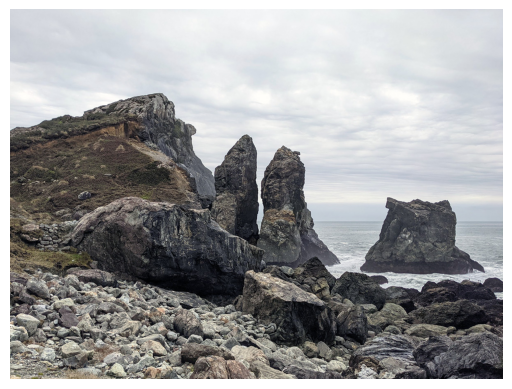

In [ ]:
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

Inception base network is used to generate crazy paradeolia images on the base image

In [ ]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights = "imagenet", include_top = False)


87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

In [ ]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.0,
    "mixed6": 1.0,
    "mixed7": 4.0,
}
#these are the few of the layers in the model. we are trying to maximize these activations and thereby get trippy images


In [ ]:
output_dict = dict([(layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]])

In [ ]:
feature_extractor = keras.Model(inputs = model.inputs, outputs = output_dict)

In [ ]:
feature_extractor

the idea is to use certain layers (high level or low level) to maximize their activations using a loss function with gradient ascent.
Usage of low level layers introduce geometric patterns into the input image and high level layers introduce abstract patterns like dogs, cats, birds -> classes in iamgenet dataset. In this case we have a bunch of layers and this can be configured to achieve different visual patterns.

In [ ]:
#Deep dream loss
def compute_loss(image):
  features = feature_extractor(image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    loss += coeff * tf.reduce_mean(tf.square(activation[:,2:-2, 2:-2,:]))
  return loss



In [ ]:
#Gradient ascent process to tune the image to maximize the activation across layers
import tensorflow as tf
@tf.function
def gradient_ascent_step(image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image)
  grads = tape.gradient(loss,image)
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return loss,image



In [ ]:
def gradient_ascent_loop(image, iterations, learning_rate, max_Loss = None):
  for i in range(iterations):
    loss,image = gradient_ascent_step(image,learning_rate)
    if max_Loss is not None and loss > max_Loss:
      break
    print(f"the loss at step {i} is {loss:.2f}")
  return image

once the gradient ascent loop is ready, we are ready to train the deep dream network, but before that, we train not on the image at original scale, but at different scales called octaves. this injects necessary details at different scales thus learning to produce patterns at a latent space corresponding to different weightage of pixels.


In [ ]:
step = 20
num_octaves = 4 #scale
octave_scale = 1.8 # upscaling by 40 percent for every octave
max_loss = 20
iterations = 30



Image processing utilities

In [ ]:
import numpy as np
def preprocess_image(image_path):
  img = keras.utils.load_img(image_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img


In [ ]:
def deprocess_img(img):
  img = img.reshape((img.shape[1], img.shape[2], 3))
  #undo preprocessing done in inception_v3 preprocessing
  img /= 2.0
  img += 0.5
  img *= 255
  img = np.clip(img,0,255).astype(np.uint8)
  return img

we initially work with downscaled original image, add trippy patterns into it while training and then we upscale to successive octaves and further introduce patterns. while upscaling, we might encounter blur or pixelated image.to bring back details from original image, we can introduce the difference between original image and upscaled shrunk original image which weeds out the inconsistencies in pixels introduced due to shrink+upscale operations

In [ ]:
original_image = preprocess_image(base_image_path)

In [ ]:
original_image.dtype,original_image.shape

(dtype('float32'), (1, 900, 1200, 3))

In [ ]:
original_shape = original_image.shape[1:3]

In [ ]:
print(original_shape)

(900, 1200)


In [ ]:
successive_shapes = [original_shape]

In [ ]:
for i in range(1,num_octaves):
  successive_shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(successive_shape)


In [ ]:
successive_shapes = successive_shapes[::-1]

In [ ]:
shrunk_original_image= tf.image.resize(original_image, successive_shapes[0])
img = tf.identity(original_image) # create a copy to retain the image


In [ ]:
shrunk_original_image.shape

TensorShape([1, 459, 612, 3])

In [ ]:
for i,shape in enumerate(successive_shapes):
  print(f"processing octave {i} with shape {shape}")
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(img,iterations = iterations, learning_rate = step, max_Loss = max_loss)
  upscaled_shrunk_original_image = tf.image.resize(shrunk_original_image,shape)
  same_size_original_image = tf.image.resize(original_image, shape)
  lost_detail = same_size_original_image - upscaled_shrunk_original_image
  img += lost_detail
  shrunk_original_image = tf.image.resize(original_image, shape)


processing octave 0 with shape (154, 205)
the loss at step 0 is 1.39
the loss at step 1 is 1.74
the loss at step 2 is 2.91
the loss at step 3 is 3.17
the loss at step 4 is 4.13
the loss at step 5 is 4.20
the loss at step 6 is 4.51
the loss at step 7 is 4.94
the loss at step 8 is 4.99
the loss at step 9 is 5.86
the loss at step 10 is 6.56
the loss at step 11 is 7.18
the loss at step 12 is 7.54
the loss at step 13 is 8.07
the loss at step 14 is 8.36
the loss at step 15 is 9.23
the loss at step 16 is 9.23
the loss at step 17 is 10.33
the loss at step 18 is 10.32
the loss at step 19 is 10.37
the loss at step 20 is 11.41
the loss at step 21 is 11.80
the loss at step 22 is 13.33
the loss at step 23 is 13.21
the loss at step 24 is 13.40
the loss at step 25 is 15.13
the loss at step 26 is 16.75
the loss at step 27 is 17.26
processing octave 1 with shape (277, 370)
the loss at step 0 is 0.74
the loss at step 1 is 1.09
the loss at step 2 is 1.41
the loss at step 3 is 1.83
the loss at step 4 is 2

In [ ]:
keras.utils.save_img("/content/dream.png", deprocess_img(img.numpy()))

because inception v3 scales the image to 229x229 and our code involves lot of resize, it works well with images close 300 or 400 resolution.

As expected, placing more weights on activations found later introduce class like images i.e dogs, cats etc and placing more weights on initial activations layers introduce geometric patterns.

Neural style transfer

in vision applications ,applying the style of a image to a source image to produce the source image in the style of reference image

mathematically , this would amount to a loss function , loss= style(reference_image)-style(combination_image) + content(source_image)-content(combination_image), assuming that we can get content and style through a mathematical function from the image. the - operator here could mean l2 norm.

Convolution neural networks indeed give a way to mathematically extract content and style from the image through their spatial and temporal filters , aka kernels.

Conv kernels at different activation layers encode information at different spatial scales. the ones in the higher layers encode global abstract patterns such as content. so, l2 norm of the activation of upper layer of a convnet of original vs combined image is a good candidate.

For style, the loss is not straigthforward . the convnets at different spatial scales contribute to textures, visual patterns, style. so , a new function called the gram matrix is introduced which is the inner product of the activation features of convnets at different scales.

Neural style transfer in keras

In [1]:
from tensorflow import keras

In [2]:
base_image_path = keras.utils.get_file("sf.jpg", origin = "https://img-datasets.s3.amazonaws.com/sf.jpg")

In [3]:
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")
#Van Gogh's style

In [4]:
original_width, original_height = keras.utils.load_img(base_image_path).size
print(original_width, original_height)

1947 1460


In [5]:
#resize image to height of 400 and maintain aspect ratio
img_height = 400
img_width = round(img_height / original_height * original_width)
print(img_width)

533


In [6]:
#image preprocessing - based on VGG19 conv net
import numpy as np
def preprocess_image(image_path):
  img = keras.utils.load_img(image_path,target_size = (img_height, img_width))
  img= keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.vgg19.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img_height,img_width,3))
  img[:, :, 0] += 103.939 # these values do reverse of preprocess_input in vgg19.zero centering by removing the mean value
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  img = img[:,:,::-1]
  img = np.clip(img, 0, 255).astype(np.uint8)
  return img



In [7]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

2024-05-19 16:58:04.378891: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-05-19 16:58:04.378919: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-19 16:58:04.378924: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-19 16:58:04.378959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 16:58:04.378976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


80134624/80134624 [==============================] - 40s 0us/step


In [8]:
print(base_image_path)

/Users/divyeshkanagavel/.keras/datasets/sf.jpg


In [9]:
#pick up outputs for every layer
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [10]:
# prompt: Come up with a content loss based on my markdown comments above

#content loss is the l2 norm of the activation of upper layers of a convnet of original vs combined image
def content_loss(base_image, combination_image):
  #base_image_features = feature_extractor(base_image)
  #combination_image_features = feature_extractor(combination_image)
  content_loss = tf.reduce_mean(tf.square(combination_image- base_image))
  return content_loss


In [11]:
#style loss
def gram_matrix(x):
  x = tf.transpose(x, (2,0,1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

In [12]:
def style_loss(style_img, combination_img):
  S = gram_matrix(style_img)
  C = gram_matrix(combination_img)
  num_channels = 3
  size = img_height * img_width
  return tf.reduce_sum(tf.square(S-C)) / (4 * (num_channels**2) * (size**2))


In [13]:
#we add another loss called variation loss - a sort of regularization loss to prevent the pixels from changing
#too much and end up becoming pixelated.
# it is basically a measure of pixel values between neighboring pixels, indicates noise in the image -> reduce the noise and have as little pixelation as possible.
def variation_loss(x):
  a = tf.square(x[:,:img_height-1, :img_width-1,:] - x[:,1:,:img_width-1,:])
  b = tf.square(x[:,:img_height-1, :img_width-1,:]- x[:,:img_height-1,1:,:])
  return tf.reduce_sum(tf.pow((a+b),1.25))


for content loss, we try to minimize the activation of block5_conv2 of both content image and style image. for style loss, we take multiple conv layer outputs. we also assign weights to the loss contribution -> more weight ,more the influence of content or style.


In [15]:
style_layer_names = ["block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"]

In [16]:
content_layer_name = "block5_conv2"

In [61]:
total_variation_weight = 1e-6
style_weight = 1e-2
content_weight = 2.5e-8

In [62]:
def compute_loss(base_image, style_ref_image, combination_image):
    input_tensor = tf.concat([base_image, style_ref_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
    base_image_features, combination_features
    )   

    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    for layer_name in style_layer_names:
        layer_features = features[layer_name] 
        style_reference_features = layer_features[1, :, :, :] 
        combination_features = layer_features[2, :, :, :]
        
        style_loss_ = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_
    loss += total_variation_weight * variation_loss(combination_image)
    return loss



in the original paper - L-BFGS algorithm was used, but here we use stochastic gradient descent.

In [63]:
import tensorflow as tf
def compute_loss_and_grads(base_image, style_ref_image, combination_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(base_image, style_ref_image, combination_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [64]:
optimizer = keras.optimizers.legacy.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.01, decay_steps = 100, decay_rate = 0.96
))

In [65]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

In [66]:
iterations = 800
for i in range(1,iterations+1):
    loss,grads = compute_loss_and_grads(base_image, style_reference_image, combination_image)
    optimizer.apply_gradients([(grads,combination_image)])
    if i % 400 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")


Iteration 400: loss=4291194.00
Iteration 800: loss=2686919.00


In [71]:
img = deprocess_image(combination_image.numpy())

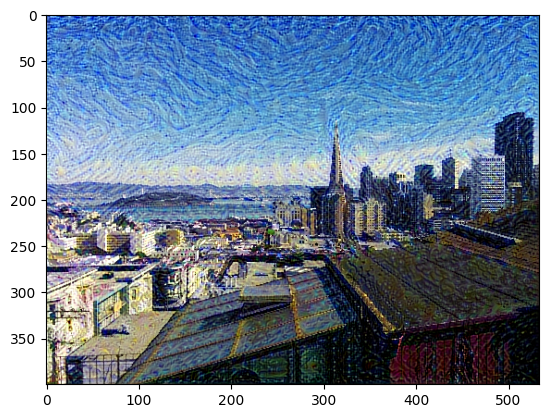

In [72]:
import matplotlib.pyplot as plt
plt.imshow(img)

we can place more weightage on style or content and get different images accordingly. 
There is a faster way to produce such images -> these are basically image processing techniques applied on image with a style reference image which can be handled by convolution feedforward network. 
So, we can produce some such images and use them as target images and then train a simple convnet image to produce such images given input images. This way we can generate many more images faster given there is a good dataset available.